# LLM Training Data Augmentation - Classification of Kaggle Disaster Data

The goal of this notebook is to explore whether a HuggingFace model (HFM) can enhance the performance of non-transformer-based text classification models by augmenting the training data.

## Data

The data used in this project comes from the kaggle *Natural Language Processing with Disaster Tweets* competition at:  

https://www.kaggle.com/competitions/nlp-getting-started/data

This data consists of two files:
+ *train.csv* - 7613 labled tweets
+ *test.csv* - 3236 unlabled tweets

Because the *test.csv* labels are not available, the *train.csv* file was split into the following two files:

+ train_model.csv - data used to train model, 6090 labeled tweets
+ train_test.csv - held out and not used to train model, used as *pseudo-test* data, 1523 labeled tweets (~20% of the original training sample)

## Non-Transformer Models

Two types of models are created and compared:

1. Logistic Regression - This serves as the baseline
2. Single-Hidden layer neural network with 1000 nodes in the hidden layer

## HuggingFace Models

The *TBD* Hugging Face transformer model was used to provide both uninformed and informed assistance through augmenting the data used to train the non-transformer-based models.

## Encodings

Two types of encodings are used to vectorize the inputs:

1. One-hot encoding
2. Twitter GloVe embedding: https://nlp.stanford.edu/data/glove.twitter.27B.zip


# Preprocessing

## Manual inspection of train.csv

The following issues observered in the data are listed below.  They are numbered to indicate the order in which they were processed.  For example, spillover lines were fixed first, then URLs, etc.  This order is important because removing things like punctuation too early would make things like identifying user names or hashtags in a tweet impossible or make URLs invalid.

### 1. Spillover lines

The first issue we see with this data is that while most of the samples are on there own line. Here are few examples:

>`61,ablaze,,"on the outside you're ablaze and alive`  
>`but you're dead inside",0`  
>`74,ablaze,India,"Man wife get six years jail for setting ablaze niece`  
>`http://t.co/eV1ahOUCZA",1`  
>`86,ablaze,Inang Pamantasan,"Progressive greetings!`  
>  
>`In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0`  
>`117,accident,,"mom: 'we didn't get home as fast as we wished'`  
>`me: 'why is that?'`  
>`mom: 'there was an accident and some truck spilt mayonnaise all over ??????",0`

The custom function `fix_spillover_lines` was written to fix these lines. Its code is available in the projtools module.

### 2. Normalizing URLs

Some tweet contain one or more URLs.  I assume that the content of a ULR does not contain any useful, but since a `<url>` token exists in the twitter gloVe embeddings, URLS will be replaced by this token.  

Although the actual URL may not contain much useful information, the count of URLs occuring in a tweet may be a useful feature and are counted before they are normalized.  About 90% of the URLs in the training data are of the form `http://t.co/<10 digit hash>`. For example: `http://t.co/9FxPiXQuJt`.  In about 10% of cases, these URLs start with `https:\\`.

#### 2.1 Counting URLs in each tweet

The custom function `make_url_counts` is used to create a `url_count` feature/column.  This needs to be called before calling `replace_urls`.

#### 2.2 Normalizing URLs

The `replace_urls` function replaces each URL by the string "<url>" for the reasons stated above.  The needs to be called after `replace_urls` is called.


### 3 Process Twitter-specifc characters

Because the `@` and `#` characters have special meaning in tweets, they need to be processed before removing other punctuation.  When a `@<username>` is seen in a tweet, it is a reference to a user whose name is `username`.  When a `#<hashname>` is seen in a tweet, it specifies a hashtag which is a reference to all tweet tweets that use the `hashname` hashtag.  In processing these characters, `@<username>` is converted to `<user> username` and `#<hashname>` is converted to `<hashtag> hashname`.  These replacement tokens were selected because they also have mappings in the embeddings file described in the **Normalizing URLs** section.

### 4. Tokenize text and clean up non-words

#### 4.1 Contractions

Contraction fragments are included as vectorized tokens in the twitter gloVe embeddings which means that we don't need to expand these manually.  The spaCy tokenizer will separate the first word from the contraction fragments: e.g "you're" will be tokenized into `["you", "'re"]`.  Because the embeddings file has a listing for the contraction fragment token `'re` (as well as other contraction fragments such as 'm, 's, 'll, etc.), we don't need to convert these to their actual word forms (e.g. "am", "is", "will", etc.) before vectorizing.

#### 4.2 Remove remaining punctuation

The custom function `replace_with_space` is run to remove any remaining punctuation.

#### 4.3 Remove digits

The function `replace_numbers` is run to replace sets of consecutive digits digits with the token `<number>`.  As with the other token replacements, this one also was chosen because it has a mappling in the embeddings file.



In [1]:
import numpy as np
import string as st
import matplotlib as mp
import matplotlib.pyplot as plt

# To get around the "UnicodeDecodeError: 'charmap' codec can't decode byte ..." error,
# need specify encoding when reading this data in as described in the solution I upvoted here:
# https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character
# with open("./data/train.csv", encoding="utf8") as f:  # works, but setting errors removes unneeded chars
with open("./data/train.csv", encoding="utf8", errors='ignore') as f_train:
    content_train = f_train.readlines()

with open("./data/test.csv", encoding="utf8", errors='ignore') as f_test:
    content_test = f_test.readlines()

print(len(content_train), len(content_test))  # 8562, 3700  BEFORE applying any fixes

8562 3700


In [2]:
# print some examples of spillover lines
with open("./debug/train_debug_spillover_chunk.txt", encoding="utf8", errors='ignore') as f:
    content_train_debug = f.readlines()

for i in [0, 42, 43, 53, 54, 64, 65, 66]:
    print(content_train_debug[i].strip())

id,keyword,location,text,target
61,ablaze,,"on the outside you're ablaze and alive
but you're dead inside",0
74,ablaze,India,"Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA",1
86,ablaze,Inang Pamantasan,"Progressive greetings!

In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0


In [3]:
import projtools as pt
# test the fix for the spillover lines on the training data
fixed_train_debug = pt.fix_spillover_lines(content_train_debug)

# for i, line in enumerate(fixed_list):
#     print(i, line)

# check that good lines are still good and spillover lines (*) are fixed
#id = header 32  25 *61 *74 *86 *117 119 120
for j in [0, 22, 36, 42, 52, 62, 81, 83, 84]:
    print(fixed_train_debug[j])  # spillover lines are now consolidated to a single line

fix_spillover_lines fixed 10 lines...
id,keyword,location,text,target
32,,,London is cool ;),0
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0
61,ablaze,,"on the outside you're ablaze and alive but you're dead inside",0
74,ablaze,India,"Man wife get six years jail for setting ablaze niece http://t.co/eV1ahOUCZA",1
86,ablaze,Inang Pamantasan,"Progressive greetings!  In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0
117,accident,,"mom: 'we didn't get home as fast as we wished' me: 'why is that?' mom: 'there was an accident and some truck spilt mayonnaise all over ??????",0
119,accident,,Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident??,0
120,accident,"Arlington, TX",#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k,1


In [4]:
# fix the spillover lines in the train and test data, then write out fixed data
# fixed_train = pt.fix_spillover_lines(content_train)
# with open(file='./data/train_clean_v01.csv', mode='w', encoding="utf8", errors='ignore') as f_train_out:
#     for line in fixed_train:
#         f_train_out.write(line)
#         f_train_out.write('\n')

# fixed_test = pt.fix_spillover_lines(content_test)
# with open(file='./data/test_clean_v01.csv', mode='w', encoding="utf8", errors='ignore') as f_test_out:
#     for line in fixed_test:
#         f_test_out.write(line)
#         f_test_out.write('\n')
#
# OUTPUT:
# fix_spillover_lines fixed 1385 line...
# fix_spillover_lines fixed 648 line...

## Spillover line counts

The `fix_spillover_lines` prints the number of lines it fixed before returning a list of fixed lines. Both files has roughly similar portions of their data that needed fixing:
+ train.csv - 1385 lines (1385 / 8562 = 16%) were fixed/consolidated
+ test.csv - 648 lines (648 / 3700 = 17.5%) were fixed/consolidated

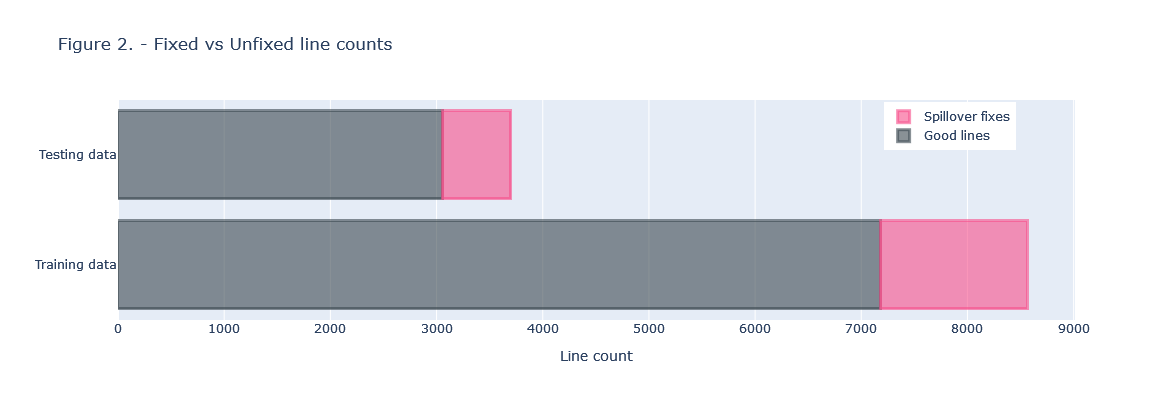

In [57]:
import plotly.graph_objects as go

fig_fix_counts = go.Figure()
fig_fix_counts.add_trace(
    go.Bar(
        y = ['Training data', 'Testing data'],
        x = [8562 - 1385, 3700 - 648],
        name = 'Good lines',
        orientation = 'h',
        marker=dict(
            color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 0.6)', width=3)
        )
    )
)
fig_fix_counts.add_trace(
    go.Bar(
        y = ['Training data', 'Testing data'],
        x = [1385, 648],
        name = 'Spillover fixes',
        orientation = 'h',
        marker=dict(
            color='rgba(246, 78, 139, 0.6)',
            line=dict(color='rgba(246, 78, 139, 0.6)', width=3)
        )
    )
)

fig_fix_counts.update_layout(barmode='stack')
fig_fix_counts.update_layout(title='Figure 2. - Fixed vs Unfixed line counts',
                             xaxis_title='Line count',
                             yaxis_title='',
                             legend=dict(yanchor="top",
                                         y=0.99,
                                         xanchor="left",
                                         x=0.80),
                  autosize=False,
                  width=900,
                  height=400)
fig_fix_counts.show()

## Missing tweets or targets?

In [53]:
import pandas as pd

df_train = pd.read_csv("./data/train_clean_v01.csv", encoding="utf8")
df_test = pd.read_csv("./data/test_clean_v01.csv", encoding="utf8")

print(pd.isnull(df_train["text"]).sum())    # no missing tweets, confirmed by histograms and min len()
print(pd.isnull(df_train["target"]).sum())  # no missing targets

0
0


In [45]:
# %%cmd
# dir

## Duplicated tweets?

In [54]:
# any duplicate id values?
# df_duplicated_ids_train = df_train[df_train.duplicated(['id'], keep=False)]  # considering just text duplicated, keep=F=show all duplicated rows
# df_duplicated_ids_train.shape  # (0, 5) so none

(0, 5)

In [50]:
# print all the rows of the dataframe


df_duplicated_rows_train = df_train[df_train.duplicated(['text'], keep=False)]  # considering just text duplicated, keep=F=show all duplicated rows
df_duplicated_rows_train = df_duplicated_rows_train.sort_values(['text'])  # group the duplicate tweets together
df_duplicated_rows_train.to_csv("./data/df_train_duplicates.csv", encoding='utf-8')
print(df_duplicated_rows_train.shape)
print(df_duplicated_rows_train.sort_values(['text']).to_string())  # 110 duplicated tweets in training

(179, 5)
         id                keyword                     location                                                                                                                                            text  target
4290   6094               hellfire     Jubail IC, Saudi Arabia.      #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect       0
4299   6105               hellfire   ?????? ??? ?????? ????????      #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect       0
4312   6123               hellfire           ?????? ???? ??????      #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect       1
6363   9095         suicide%20bomb                      Nigeria    #Bestnaijamade: 16yr old PKK suicide bomber who detonated bo

In [ ]:
duplicated_rows_train = df_train[df_train.duplicated(['text', 'target'])]  # considering text and target togther
duplicated_rows_train

In [24]:
duplicated_rows_test = df_test[df_test.duplicated(['text'])]
print(duplicated_rows_test.shape)
duplicated_rows_test  # ?? duplicated tweets in testing set

(20, 4)


,id,keyword,location,text
53,177,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
286,924,bioterrorism,NaN,To fight bioterrorism sir.
600,1947,burning%20buildings,US of Eh,.@denisleary Not sure how these folks rush int...
612,1998,bush%20fires,NaN,Bushfire causes first victim in Albania :: Th...
1051,3449,derail,"w/ @_ridabot, probably",@PumpkinMari_Bot lemme just derail this real q...
1072,3546,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth...
1234,4056,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...
1302,4286,drowning,NaN,Boy saves autistic brother from drowning: A ni...
1489,4949,exploded,NaN,that exploded &amp; brought about the beginnin...
1537,5123,fatal,Gurgaon,11-Year-Old Boy Charged With Manslaughter of T...


## Class balance

In [6]:
# with open("./data/test_clean_v01.csv", encoding="utf8", errors='ignore') as f:
#     v01_test_lines = f.readlines()

total_train_samples = df_train.shape[0]
total_test__samples = df_test.shape[0]
print(total_train_samples, total_test__samples)  # 7613 3263
print(df_train.shape, df_test.shape)

7613 3263
(7613, 5) (3263, 4)


In [7]:
class1_train_samples = df_train['target'].sum()
class0_train_samples = total_train_samples - class1_train_samples
print(class0_train_samples, class1_train_samples)  # 4342 3271, a little class 0 heavy...

4342 3271


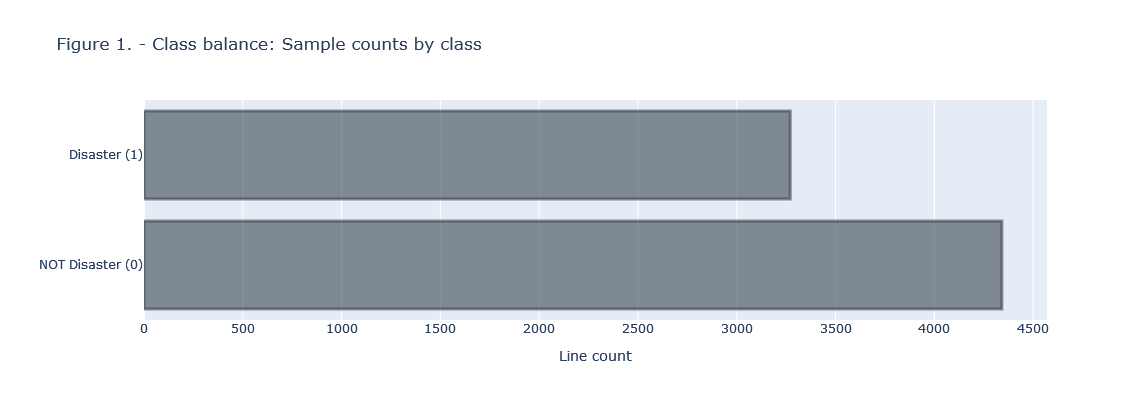

In [56]:
fig_class_balance = go.Figure()
fig_class_balance.add_trace(
    go.Bar(
        y = ['NOT Disaster (0)', 'Disaster (1)'],
        x = [4342, 3271],
        name = 'Training data',
        orientation = 'h',
        marker=dict(
            color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 0.6)', width=3)
        )
    )
)
fig_class_balance.update_layout(title='Figure 1. - Class balance: Sample counts by class',
                                xaxis_title='Line count',
                                yaxis_title='',
                                legend=dict(yanchor="top",
                                            y=0.99,
                                            xanchor="left",
                                            x=0.80),
                                 autosize=False,
                                 width=900,
                                 height=400)

fig_class_balance.show()

## Normalizing URLs

In [9]:
# normalize urls
with open("./data/train_clean_v01.csv", encoding="utf8", errors='ignore') as f:
    v01_train_lines = f.readlines()

with open("./data/test_clean_v01.csv", encoding="utf8", errors='ignore') as f:
    v01_test_lines = f.readlines()

# first, count the urls before replacing them
v02_train_lines = pt.make_url_counts(v01_train_lines)
v02_test_lines = pt.make_url_counts(v01_test_lines)

# second, replace the urls with the <url> token
v02_train_lines = pt.replace_urls(v02_train_lines)
v02_test_lines = pt.replace_urls(v02_test_lines)


# look at some lines that have urls to check if they are getting counted
for i in range(32, 42):
    print(v02_train_lines[i])
print()
for j in range(16, 26):
    print(v02_test_lines[j])

# write file with url fixes
# pt.write_lines_to_csv(v02_train_lines, "./data/train_clean_v02.csv")
# pt.write_lines_to_csv(v02_test_lines, "./data/test_clean_v02.csv")

48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze <url>,1,1
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT <url>,0,1
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. <url>,1,1
52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,0
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE <url>,0,1
54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,0,0
55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - <url>,1,1
56,ablaze,,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  <url>,1,1
57,ablaze,Paranaque City,Ablaze for you Lord :D,0,0
59,ablaze,Live On Webcam,Check these out: <url> <url> <url> <url> #nsfw,0,4

46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market <url

## Process Twitter-specifc characters

In [10]:
# process twitter-specific chars
with open("./data/train_clean_v02.csv", encoding="utf8", errors='ignore') as f:
    v02_train_lines = f.readlines()

with open("./data/test_clean_v02.csv", encoding="utf8", errors='ignore') as f:
    v02_test_lines = f.readlines()

v03_train_lines = pt.replace_twitter_specials(v02_train_lines)
v03_test_lines = pt.replace_twitter_specials(v02_test_lines)

# write file with twitter-specific chars fixes
# pt.write_lines_to_csv(v03_train_lines, "./data/train_clean_v03.csv")
# pt.write_lines_to_csv(v03_test_lines, "./data/test_clean_v03.csv")

## Tweet length by class

Tweets that are disaster-response related tend to be longer on average than those that aren't as shown in Figure 1. below.

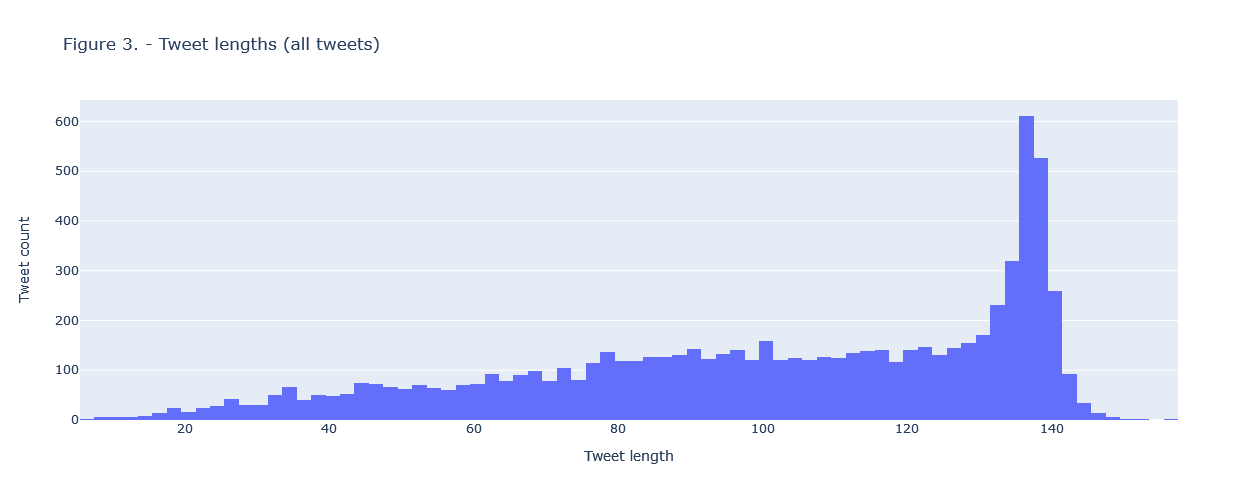

In [14]:
import pandas as pd
import spacy as sp

# break out the text column from line consolidated data so it can be operated on separately
df_train01 = pd.read_csv('./data/train_clean_v01.csv', encoding="utf8")
# df_test01 = pd.read_csv('./data/test_clean_v01.csv', encoding="utf8")

# first, look at overall distribution
train_tweet_lens = []
train_text_lines = df_train01['text'].to_list()
for text in train_text_lines:
    train_tweet_lens.append(len(text))

train_tweet_lens = np.array(train_tweet_lens)
fig_hist = go.Figure(data=[go.Histogram(x=train_tweet_lens)])
fig_hist.update_layout(title='Figure 3. - Tweet lengths (all tweets)',
                       xaxis_title='Tweet length',
                       yaxis_title='Tweet count',
                       legend=dict(yanchor="top",
                                   y=0.99,
                                   xanchor="left",
                                   x=0.01),
                       autosize=False,
                       width=900,
                       height=500)
fig_hist.show()

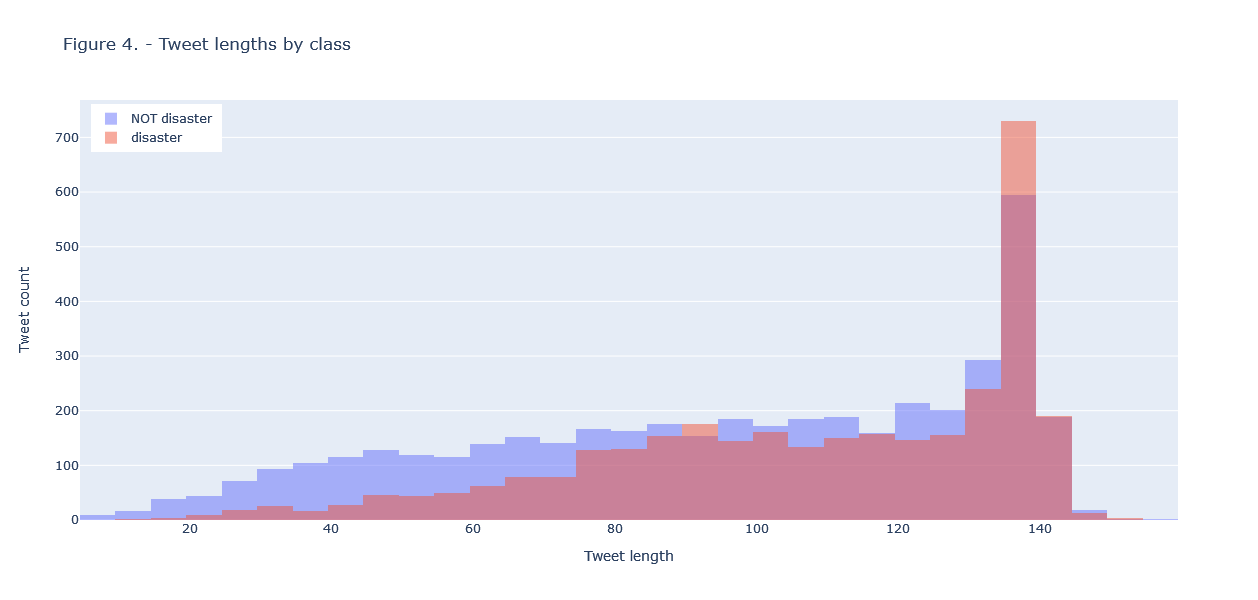

In [12]:
# print(df_train01.columns)  # ['id', 'keyword', 'location', 'text', 'target']
# separate the classes
train_class0_lens = df_train01.loc[df_train01['target'] == 0, ['text', 'target']]  # not disaster
train_class1_lens = df_train01.loc[df_train01['target'] == 1, ['text', 'target']]  # disaster
# compute the tweet lengths
train_class0_lens['text_len'] = train_class0_lens.apply(lambda row: len(row['text']), axis=1)
train_class1_lens['text_len'] = train_class1_lens.apply(lambda row: len(row['text']), axis=1)

# create overlay of the 2 distributions
fig_overlay_hists = go.Figure()
fig_overlay_hists.add_trace(go.Histogram(x=train_class0_lens['text_len'], name="NOT disaster"))
fig_overlay_hists.add_trace(go.Histogram(x=train_class1_lens['text_len'], name="disaster"))

# Overlay both histograms
fig_overlay_hists.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig_overlay_hists.update_traces(opacity=0.50)

fig_overlay_hists.update_layout(title='Figure 4. - Tweet lengths by class',
                  xaxis_title='Tweet length',
                  yaxis_title='Tweet count',
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="left",
                              x=0.01),
                  autosize=False,
                  width=900,
                  height=600)

fig_overlay_hists.show()

In [15]:
# How many tweets are missing (0 length)?
train_class0_lens.sort_values(['text_len']).head(10)

,text,target,text_len
4890,Bad day,0,7
5115,Err:509,0,7
1882,Crushed,0,7
4971,Meltdown,0,8
3670,fatality,0,8
30,The end!,0,8
24,LOOOOOOL,0,8
3667,Fatality!,0,9
28,Cooool :),0,9
6705,Thunder???,0,10


In [19]:
print(train_class0_lens['text_len'].min(), train_class1_lens['text_len'].min())  # all tweets >=7 chars
print(train_class0_lens.shape[0], train_class1_lens.shape[0])

7 14
4342 3271


In [ ]:
# any missing target values


## Expanding contractions

Words like *I'm, you're, she's* are actually two words (I am, you are, she is).